# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***

The goals of this project are the following:

<ul>
<li>Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
<li>Apply a distortion correction to raw images.
<li>Use color transforms, gradients, etc., to create a thresholded binary image.
<li>Apply a perspective transform to rectify binary image (birds-eye view).
<li>Detect lane pixels and fit to find the lane boundary.
<li>Determine the curvature of the lane and vehicle position with respect to center.
<li>Warp the detected lane boundaries back onto the original image.
<li>Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
</ul>

---

## Import Packages

In [1]:
### Importing necessary packages

import numpy as np                  # For handling images
import glob                         # For iterating through multiple image files
import cv2                          # For image manipulation
import matplotlib.pyplot as plt     # For plotting images

# For plotting to display inline within the notebook
%matplotlib inline

print("All package import complete")

All package import complete


## Define Global Variables

In [2]:
### Global variables and constants defined here

detected_lines = []                  # Global variable to hold all detected lines
reset_lanes = True                   # Flag that drives detection of fresh lanes
terrain_type = None                  # Variable that indicates the terrain type
mtx = dist = None                    # Camera caliberation parameters
perspective_M = perspective_Minv = None  # Perspective and inverse perspective
baseline_lane_width = None           # Baseline lane width in px calculated from reference image
cb = np.empty([360,1930,3])          # Holding variable for image concatenation        
c1 = np.empty([370,640,3])           # Holding variable for image concatenation
c2 = np.empty([360,640,3])           # Holding variable for image concatenation

class Line():                        # Objects of this Line class hold details of a detected lines
    def __init__(self):

        self.fresh_lane = None
        self.good_lane = None
        self.continous_bad_lanes = 0
        self.leftx_base = None
        self.rightx_base = None
        self.leftx = None
        self.lefty = None
        self.rightx = None
        self.righty = None
        self.left_fit = None
        self.right_fit = None
        self.left_curverad = None
        self.right_curverad = None
        self.center_offset_m = None
        self.lane_width = None
        self.smooth_leftx_base = 0
        self.smooth_rightx_base = 0
        self.smooth_left_fit = [0,0,0]
        self.smooth_right_fit = [0,0,0]

print("All global variable definition complete")

All global variable definition complete


## Define support functions

The helper functions needed for this project are defined in this section

In [3]:
### Support Functions

""" The helper functions needed to identify lanes are defined in this section """

def showImg(img):
    """ Combines plt.imshow() and plt.show() so that
        grayscale images can be displayed with a single line funtion call"""
    plt.imshow(img)
    plt.show()
    return

def showGrayImg(img):
    """ Combines plt.imshow() and plt.show() so that 
        images can be displayed with a single line funtion call"""
    plt.imshow(img, cmap="gray")
    plt.show()
    return

def undistort(img):
    """ Undistorts a given image using 
        Camera caliberations"""
    return cv2.undistort(img, mtx, dist, None, mtx)

def grayscale(img):
    """Applies the Grayscale transform
       This will return an image with only one color channel"""
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gradient(gray, orient, sobel_kernel, thresh):
    """ Calculates directional gradient in the required orientation
        Applies threshold"""
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def gradient_mag(gray, sobel_kernel, mag_thresh):
    """ Calculates gradient magnitude
        Applies threshold"""

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt( (sobelx*sobelx) + (sobely*sobely) )
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def gradient_dir(gray, sobel_kernel, dir_thresh):
    """ Calculates gradient direction
        Applies threshold"""
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
#    scaled_dir_grad = np.uint8(255*dir_grad/np.max(dir_grad))
    dir_binary = np.zeros_like(dir_grad)
    dir_binary[(dir_grad >= dir_thresh[0]) & (dir_grad <= dir_thresh[1])] = 1
    return dir_binary

def s_select(img, thresh):
    """ 1) Converts image to HLS color space
        2) Apply a threshold to the S channel
        3) Return a binary image of threshold result """
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    img_s = img[:,:,2]

    sbinary = np.zeros_like(img_s)
    sbinary[(img_s > thresh[0]) & (img_s <= thresh[1])] = 1
    return sbinary

def l_select(img, thresh):
    """ 1) Converts image to HLS color space
        2) Apply a threshold to the S channel
        3) Return a binary image of threshold result """
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    img_l = img[:,:,1]

    lbinary = np.zeros_like(img_l)
    lbinary[(img_l > thresh[0]) & (img_l <= thresh[1])] = 1
    return lbinary

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    global terrain_type
    
    if terrain_type == 'h':
        mask_top_y = 470
        mask_bottom_y = 720
        mask_top_left_x = 360
        mask_top_right_x = 680
        mask_bottom_right_x = 1190
        mask_bottom_left_x = 75
    elif terrain_type == 'c':
        mask_top_y = 470
        mask_bottom_y = 720
        mask_top_left_x = 580
        mask_top_right_x = 750
        mask_bottom_right_x = 1150
        mask_bottom_left_x = 180
    else:
        mask_top_y = 440
        mask_bottom_y = 720
        mask_top_left_x = 530
        mask_top_right_x = 740
        mask_bottom_right_x = 1165
        mask_bottom_left_x = 150
        
    
    vertices = np.array([[(mask_top_left_x, mask_top_y), (mask_top_right_x, mask_top_y),  \
                          (mask_bottom_right_x, mask_bottom_y), (mask_bottom_left_x, mask_bottom_y)]],  \
                             dtype=np.int32) # vertices of the masked area

    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

def calculate_curvature(y_eval, fit):
    """Calculates the radius of curvature of a given line"""
    # y_eval : y-value where we want radius of curvature
    # fit : left or right line fit
    return ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) / np.absolute(2*fit[0])

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    return lines

def img_collage(marked_img):
    """ Concatenate images into a single image
        This helps view different perspectives of the image
        at the same time helping with debugging"""
    global c1, c2
    c3 = np.concatenate((c1,c2),0)
    marked_img = cv2.resize(marked_img,(1280, 720))
    c0 = cv2.copyMakeBorder(marked_img,0,10,0,10,cv2.BORDER_CONSTANT, value=[255,255,0])
    ct = np.concatenate((c0,c3),1)
    c = np.concatenate((ct,cb),0)
    c = cv2.resize(c,(1280, 720))
    return c

## Extract warped binary image of the lanes

This function takes in a 3 channel RGB color image and returns a warped binary image with the lane markings only

In [4]:
### Function to extract a warped binary image of the lanes

""" This function takes in a 3 channel RGB olor image and 
    returns a warped binary image with the lane markings only """

    # Undistort the image
    # Create necessary color channel filters
    # Create necessary sobel filters
    # Create a combined filter that provides the best results
    # Apply mask to pick up lane pixels only
    # Warp the image

def get_binary_warp(image):

    # Undistort the camera image
    image = undistort(image)
    
    # Get image filtered by S channel
    s_chn_img = s_select(image, thresh=(100,255))
    
    # Get image filtered by L channel
    l_chn_img = l_select(image, thresh=(50,255))
    
    # Grayscale the image
    gray_img = grayscale(image)
    
    # Get image filtered by sobel x
    sobelx_img = gradient(gray_img, orient='x', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel y
    sobely_img = gradient(gray_img, orient='y', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel magnitude
    sobel_mag = gradient_mag(gray_img, sobel_kernel=3, mag_thresh=(20,100))
    
    # Get image filtered by sobel gradient direction
    sobel_dir = gradient_dir(gray_img, sobel_kernel=31, dir_thresh=(0.7,1.3))
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    #color_binary = np.dstack(( np.zeros_like(sobelx_img), sobelx_img, s_chn_img))
    
    # Combine the two binary thresholds
    combined_img = np.zeros_like(sobelx_img)
    combined_img[((s_chn_img == 1) | ((sobelx_img == 1) & (sobely_img ==1))) & ((l_chn_img == 1))] = 1

    # Pick up pixels that have high S and L channel values.  This will help address shadow conditions
    combined_img2 = np.zeros_like(sobelx_img)
    combined_img2[((s_chn_img == 1) & (l_chn_img == 1))] = 1
    
    # Pick up pixels that have high sobel x and y values.  This will help pick only strong pixels.
    combined_img3 = np.zeros_like(sobelx_img)
    combined_img3[((sobelx_img == 1) & (sobely_img ==1))] = 1

    # Combine the two binary images.  This image :
    # 1. Will capture lanes under shadows as well
    # 2. Will pick up only strong pixels that have high values both in x and y
    combined_img4 = np.zeros_like(sobelx_img)
    combined_img4[((combined_img2 == 1) | (combined_img3 ==1))] = 1
    
    """
    # Use Hough transform to filter out non-line pixels and horizontal lines
    lines = hough_lines(combined_img4, 2, np.pi/180, 100, 30, 20)
    #creating a blank to draw lines on
    line_image = np.copy(image)*0
    # Iterate over the output "lines" and draw lines on the blank
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope, intercept = np.polyfit([x1, x2], [y1, y2], 1)
            if((slope*slope) > 0.1) & ((slope*slope) < 100):       # Filters out horizontal lines 
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((combined_img4, combined_img4, combined_img4)) 
    # Draw the lines on the edge image
    combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    showImg(combo)
    """

    # Apply mask for lane region only to filter out non-lane pixels.
    masked_image = region_of_interest(combined_img4) 
    
    # Warp the image to provide a top down perspective view
    warped_image = cv2.warpPerspective(masked_image, perspective_M, gray_img.shape[::-1], flags=cv2.INTER_LINEAR)
#    showGrayImg(warped_image)

    """
    # Plot the images for review
    f = plt.figure(figsize=(30, 18))
    ax1 = plt.subplot(2, 4, 1)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=10)
    ax2 = plt.subplot(2, 4, 2)
    ax2.imshow(s_chn_img, cmap='gray')
    ax2.set_title('S Channel', fontsize=10)
    ax3 = plt.subplot(2, 4, 3)
    ax3.imshow(l_chn_img, cmap='gray')
    ax3.set_title('L Channel', fontsize=10)
    ax4 = plt.subplot(2, 4, 4)
    ax4.imshow(sobelx_img, cmap="gray")
    ax4.set_title('Gradient x', fontsize=10)
    ax5 = plt.subplot(2, 4, 5)
    ax5.imshow(sobely_img, cmap="gray")
    ax5.set_title('Gradient y', fontsize=10)
    ax6 = plt.subplot(2, 4, 6)
    ax6.imshow(combined_img, cmap="gray")
    ax6.set_title('Combined Image', fontsize=10)
    ax7 = plt.subplot(2, 4, 7)
    ax7.imshow(warped_image, cmap="gray")
    ax7.set_title('Warped View', fontsize=10)
    ax8 = plt.subplot(2, 4, 8)
    ax8.imshow(masked_image, cmap="gray")
    ax8.set_title('Masked View', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)
    f.savefig('Inflight_' + str(idx))
    plt.show()
    """
    
    # Combine images to create a collage of different perspectives
    # This makes it easy to debug as many perspective are shown at the same time
    c4 = cv2.resize(combined_img,(640, 360))
    c4 = np.dstack((c4, c4, c4))*255
    c4 = cv2.copyMakeBorder(c4,0,0,0,5,cv2.BORDER_CONSTANT, value=[255,255,0])
    cv2.putText(c4,"Filtered Binary Image", (150,30), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
#    print("c4 shape = ", c4.shape)
    c5 = cv2.resize(masked_image,(640, 360))
    c5 = np.dstack((c5, c5, c5))*255
    c5 = cv2.copyMakeBorder(c5,0,0,0,5,cv2.BORDER_CONSTANT, value=[0,0,0])
    cv2.putText(c5,"Masked Binary Image", (150,30), cv2.FONT_HERSHEY_PLAIN, 2, (255255,255))
#    print("c5 shape = ", c5.shape)
    c6 = cv2.resize(warped_image,(640, 360))
    c6 = np.dstack((c6, c6, c6))*255
    c6 = cv2.copyMakeBorder(c6,0,0,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
    cv2.putText(c6,"Warped", (150,30), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
    cv2.putText(c6,"Image", (150,60), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
#    print("c6 shape = ", c6.shape)
    global cb
    cb = np.concatenate((c4, c5, c6),1)

    return warped_image

## Detect fresh left and right lanes a warped binary image

This function takes in a warped binary image of the lanes and detects the lanes.  This function is used during the start of the pipeline and whenever multiple bad lines are detected continously

In [21]:
### This function will locate a fresh set of lane lines from a given binary warped image
"""  This function called 
     1. During the start of the pipeline to find the lanes
     2. Whenever continous bad lanes are detected - this will help as a reset"""

def find_fresh_lanes(binary_warped):
    
    print("Inside reset")
    drive_log.write("@ " + str(len(detected_lines)) + " - Inside reset\n")
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
#    plt.plot(histogram)
#    plt.show()
    

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
#    print(leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 20
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Combine images to create a collage of different perspectives
    # This makes it easy to debug as many perspective are shown at the same time
    global c2
    c2 = cv2.resize(out_img,None,fx=0.5, fy=0.5)
    c2 = cv2.copyMakeBorder(c2,0,10,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
#    showImg(c2)
 
    # Reset the flag to indicate that fresh detection has been done
    global reset_lanes
    reset_lanes = False
    
#    showImg(out_img)

    return leftx_base, rightx_base, left_lane_inds, right_lane_inds
    

## Perform sanity check on lane lines

This function performs sanity checks on the identified lane lines and decides if they are high confidence detections

In [27]:
### Perform sanity checks.
""" 1. Sanity check the left and right lanes from the current detection.
    2. Sanity check the lanes against previous good values for continuity """

def sanity_check_lanes(l):
    
    good_lane = True
    
    while True:

        # Low Pass Filter - Do the left and rigth lanes have enough pixels
        if len(l.leftx) < 20 or len(l.rightx) < 20:
            good_lane = False
            print("@", len(detected_lines),  " > low pass failure : ", len(l.leftx), len(l.rightx) )
            drive_log.write("@ " + str(len(detected_lines)) + " > low pass failure : " 
                            + str(len(l.leftx)) + str(len(l.rightx)) + "\n")
            break

        # Is the lane width reasonable (around 3.7 m)
        if not(3 < l.lane_width < 4.2):
            good_lane = False
            print("@", len(detected_lines),  " > lane width failure : ", l.lane_width)
            drive_log.write("@ " + str(len(detected_lines)) + " > lane width failure : " 
                            + str(l.lane_width) + "\n")
            break

        # Are the lane curvatures reasonable
        if l.left_curverad > 20000 or l.right_curverad > 20000:
            good_lane = False
            print("@", len(detected_lines),  " > curve check failure : ", l.left_curverad, l.right_curverad)
            break

        # Do the left and right lanes have similar curvature
        if abs(l.left_curverad - l.right_curverad) > 10000:
            good_lane = False
            print("@", len(detected_lines),  " > left and right curves similarity failure : ", l.left_curverad, l.right_curverad)
            break
            
        # Are the lanes parallel (co-eff check)
#        if abs(l.left_fit[0] - l.right_fit[0]) > abs(0.75 * l.left_fit[0]):
        if abs(l.left_fit[0] - l.right_fit[0]) > 0.0005:
            good_lane = False
            print("@", len(detected_lines),  " > 2nd order coefficient similarity failure : ", l.left_fit[0], l.right_fit[0])
            break
            
#        if abs(l.left_fit[1] - l.right_fit[1]) > abs(0.75 * l.left_fit[1]):
        if abs(l.left_fit[1] - l.right_fit[1]) > 0.35:
            good_lane = False
            print("@", len(detected_lines),  " > 1st order coefficient similarity failure : ", l.left_fit[1], l.right_fit[1])
            break
        
        if not l.fresh_lane:
            
            # Is the lane offset marginal from prev frame
                if abs(l.center_offset_m - detected_lines[-1].center_offset_m) > 0.5:
                    good_lane = False
                    print("@", len(detected_lines),  " > Continuity check failed - lane offset variation high : ", 
                          l.center_offset_m, detected_lines[-1].center_offset_m)
                    break

            # Is the left curvature offset reasonable from prev frame
                if abs(l.left_curverad - detected_lines[-1].left_curverad) > abs(3.0 * l.left_curverad):
                    good_lane = False
                    print("@", len(detected_lines),  " > Continuity check failed - left curve variation high : ", 
                          l.left_curverad, detected_lines[-1].left_curverad)
                    break
            
            # Is the right curvature offset reasonable from prev frame
                if abs(l.right_curverad - detected_lines[-1].right_curverad) > abs(3.0 * l.right_curverad):
                    good_lane = False
                    print("@", len(detected_lines),  " > Continuity check failed - right curve variation high : ", 
                          l.right_curverad, detected_lines[-1].right_curverad)
                    break

            # Is the co-eff offset reasonable from prev frame
            
        break
            
#    print("lane quality = ", good_lane)
    return good_lane

## Extract left and right lane fits from a warped binary image

This function takes in a warped binary image of the lanes and returns the left and right lane fits

In [7]:
### Function to extract the left and right line fits from a given warped binary image of the lanes

""" This function takes in a warped binary image of the lanes and 
    returns the left and right lane fits """

def get_line_fits(binary_warped):
    
#    showGrayImg(binary_warped)
    global reset_lanes
#    print('reset status', reset_lanes)

    # Identify indices of non-zero pixels from the binary image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Create a new Line object to store the lane parameters
    l = Line()
    
    if reset_lanes :
        # Fresh lanes being built
        leftx_base, rightx_base, left_lane_inds, right_lane_inds = find_fresh_lanes(binary_warped)
        l.fresh_lane = True
    else:
        # Using coeff from last good detection for plotting new lanes
        l.fresh_lane = False
        margin = 100
        left_fit = detected_lines[-1].left_fit
        right_fit = detected_lines[-1].right_fit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
        y_base = binary_warped.shape[0]
        leftx_base = left_fit[0]*(y_base**2) + left_fit[1]*y_base + left_fit[2]
        rightx_base = right_fit[0]*(y_base**2) + right_fit[1]*y_base + right_fit[2]
#        print(leftx_base, rightx_base)


    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#    showImg(out_img)

    # Fit a second order polynomial to each lane
    if len(leftx) == 0 or len(lefty) == 0:
        leftx = detected_lines[-1].leftx
        lefty = detected_lines[-1].lefty
    if len(rightx) == 0 or len(righty) == 0:
        rightx = detected_lines[-1].rightx
        righty = detected_lines[-1].righty

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
#    print("left fit =" , left_fit)
#    print("right fit =" , right_fit)


    # Calculate radius of curvature
    global baseline_lane_width
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty) / 2  # y-value where we want radius of curvature
    ym_per_pix = 30/720 # meters per pixel in y dimension  -->  Manual observation
    xm_per_pix = 3.7/baseline_lane_width # meters per pixel in x dimension
#    xm_per_pix = 3.7/700 # meters per pixel in x dimension
#    ym_per_pix = 3/7 # meters per pixel in y dimension  -->  Manual observation


    # Calculate curvature in pixels
    left_curverad = calculate_curvature(y_eval, left_fit)
    right_curverad = calculate_curvature(y_eval, right_fit)
#    print("Curvature left = ", left_curverad, "px  right = ", right_curverad, "px")
    
    # Fit new polynomials to x,y in world space to calculate curvature in meters
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
     
    # Determine lane width and offset
    lane_width = (rightx_base - leftx_base) * xm_per_pix
    lane_center = int(leftx_base + ((rightx_base - leftx_base) / 2))
    img_center = np.int(image.shape[1]/2)
    center_offset_px = img_center - lane_center
    center_offset_m = round((center_offset_px * xm_per_pix), 2)

    # Store detect lane parametes in the line object
    l.leftx_base = leftx_base
    l.rightx_base = rightx_base
    l.leftx = leftx
    l.lefty = lefty
    l.rightx = rightx
    l.righty = righty
    l.left_fit = left_fit
    l.right_fit = right_fit
    l.left_curverad = left_curverad
    l.right_curverad = right_curverad
    l.center_offset_m = center_offset_m
    l.lane_width = lane_width
    
    # Sanity check the identified lanes.
    if len(detected_lines) == 0:
        # Handle first clip of the pipeline
        l.good_lane = True
        l.continous_bad_lanes = 0
        l.smooth_left_fit = left_fit
        l.smooth_right_fit = right_fit
    else:
        l.continous_bad_lanes = detected_lines[-1].continous_bad_lanes
        l.good_lane = sanity_check_lanes(l)        

    # Create an image section that will show lane parameters
    # This makes it easy to debug
    global c1
    c1 = np.zeros_like(out_img)
    c1 = cv2.resize(c1,None,fx=0.5, fy=0.5)
    c1.fill(255)
    cv2.putText(c1,"Frame Metrics - " + str(len(detected_lines) + 1), (200,30), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lx_base = " + str(int(leftx_base)), (10,60), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rx_base = " + str(int(rightx_base)), (10,90), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"ln_width = " + str(round(lane_width,2)), (10,120), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit2 = " + str(round(left_fit[2],2)), (10,150), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit2 = " + str(round(right_fit[2],2)), (10,180), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit1 = " + str(round(left_fit[1],3)), (10,210), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit1 = " + str(round(right_fit[1],3)), (10,240), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit0 = " + str(round(left_fit[0],6)), (10,270), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit0 = " + str(round(right_fit[0],6)), (10,300), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Fresh Lane = " + str(l.fresh_lane), (300,60), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Good Lane = " + str(l.good_lane), (300,90), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Bad Lns = " + str(l.continous_bad_lanes), (300,120), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Left Curve = " + str(int(l.left_curverad)), (300,150), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Right Curve = " + str(int(l.right_curverad)), (300,180), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    c1 = cv2.copyMakeBorder(c1,0,0,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
#    print(c1.shape)
#    showImg(c1)

    # If the current lane detection is bad, use the previous good values to draw current lane
    if l.good_lane:
        l.continous_bad_lanes = 0
        i = 1
        # Smoothen the fit over the last n good detections
        for line in detected_lines[::-1]:
            l.smooth_left_fit += line.left_fit
            l.smooth_right_fit += line.right_fit
            if i == 5: 
                l.smooth_left_fit = l.smooth_left_fit / i
                l.smooth_right_fit = l.smooth_right_fit / i
                break 
            i += 1
    else:
        l.continous_bad_lanes += 1
        if l.continous_bad_lanes > 5: reset_lanes = True
        l.leftx_base = detected_lines[-1].leftx_base
        l.rightx_base = detected_lines[-1].rightx_base
        l.leftx = detected_lines[-1].leftx
        l.lefty = detected_lines[-1].lefty
        l.rightx = detected_lines[-1].rightx
        l.righty = detected_lines[-1].righty
        l.left_fit = detected_lines[-1].left_fit
        l.right_fit = detected_lines[-1].right_fit
        l.left_curverad = detected_lines[-1].left_curverad
        l.right_curverad = detected_lines[-1].right_curverad
        l.center_offset_m = detected_lines[-1].center_offset_m
        l.lane_width = detected_lines[-1].lane_width
        l.smooth_left_fit = detected_lines[-1].smooth_left_fit
        l.smooth_right_fit = detected_lines[-1].smooth_right_fit
    
    # Add the current lane lines to the detected_lines list
    detected_lines.append(l)

    return l

## Lane Marker Pipeline

This function acts as a pipeline that takes a 3 channel RGB color image as input and returns the same image with lanes marked in it.


In [8]:
### Lane Marker Pipeline
""" This function acts as a pipeline that takes a 3 channel RGB color image as input
    and returns the same image with lanes marked in it """

def lane_marker_pipeline(image):

    # Get the binary warped image of the input image
    binary_warped = get_binary_warp(image)
    
    # Identify the left and right fits from the binary warped image
    l = get_line_fits(binary_warped)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = l.smooth_left_fit[0]*ploty**2 + l.smooth_left_fit[1]*ploty + l.smooth_left_fit[2]
    right_fitx = l.smooth_right_fit[0]*ploty**2 + l.smooth_right_fit[1]*ploty + l.smooth_right_fit[2]
#    left_fitx = l.left_fit[0]*ploty**2 + l.left_fit[1]*ploty + l.left_fit[2]
#    right_fitx = l.right_fit[0]*ploty**2 + l.right_fit[1]*ploty + l.right_fit[2]

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    line_width = 15
 
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - line_width, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + line_width, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - line_width, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + line_width, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,0, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0, 255))
    result = cv2.addWeighted(out_img, 0.5, window_img, 1.0, 0)

    
    """
    # Draw images
    f = plt.figure(figsize=(30, 18))
   
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(binary_warped, cmap='gray')
    ax1.set_title('Input Image', fontsize=10)
    
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(out_img, cmap='gray')
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    ax2.set_title('Marked Image', fontsize=10)
    
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(result, cmap='gray')
    ax3.set_title('Final', fontsize=10)
    ax3.plot(left_fitx, ploty, color='yellow', linewidth=2)
    ax3.plot(right_fitx, ploty, color='yellow', linewidth=2)

    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)
    """

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
#    ax3.plot(left_fitx, ploty, color='yellow', linewidth=2)
#    ax3.plot(right_fitx, ploty, color='yellow', linewidth=2)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
#    showImg(color_warp)
    color_warp = cv2.addWeighted(color_warp, .5, window_img, .5, 0)
#    showImg(color_warp)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, perspective_Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    marked_img = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    curverad = int((l.left_curverad + l.right_curverad) / 2)
    cv2.putText(marked_img,"Radius of Curvature = " + str(curverad) + "m", (50,50), cv2.FONT_HERSHEY_PLAIN, 2.5, (255,255,255))
    if l.center_offset_m > 0:
        offset_txt = "Vehicle is " + str(abs(l.center_offset_m)) + "m right of centre"
    elif l.center_offset_m < 0:
        offset_txt = "Vehicle is " + str(abs(l.center_offset_m)) + "m left of centre"
    else:
        offset_txt = "Vehicle is at centre"
    
    cv2.putText(marked_img,offset_txt, (50,100), cv2.FONT_HERSHEY_PLAIN, 2.5, (255,255,255))
    
    
    return marked_img

## Caliberate Camera
This section caliberates the camera by using chessboard images so that images can be undistorted

In [9]:
### Caliberate Camera

"""This section caliberates the camera by using chessboard images so that images can be undistorted"""

def caliberate_camera():
    # Chessboard corners
    nx = 9
    ny = 6

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/cal*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = grayscale(img)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)

    # Get chessboard image size
    img = cv2.imread('camera_cal/calibration1.jpg')
    img_size = (img.shape[1], img.shape[0])
    print("Chess board shape = ", img_size)

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    print("Camera caliberated.  mtx = ", mtx, " dist = ", dist)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('camera_cal/test_undist.jpg',dst)

    # Visualize undistortion
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=20)
    plt.show()
    """
    return mtx, dist

## Compute Perspective Transform
This section calculates the Perspective Transform (M) that can be applied to any image later

In [10]:
### Compute Perspective Transform (M) and Inverse Transform (Minv)

""" This function calculates the Perspective Transform (M) that can be applied to any images later """

def compute_perspective():
    
    global terrain_type
    
    if terrain_type == 'h':
        reference_image = 'test_images/h1.png'
    elif terrain_type == 'c':
        reference_image = 'test_images/c1.png'
    else:
        reference_image = 'test_images/straight_lines1.jpg'

    # Read in an image with straight lanes
    img = cv2.imread(reference_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_size = (img.shape[1], img.shape[0])

    #Convert to gray scale
    gray = grayscale(img)

    # Undistorting using mtx and dist from camera caliberation
    dst = undistort(img)
   
    #Set source and destination image co-ordinates
    xoffset = 400 # offset for dst points
    yoffset = 10 # offset for dst points

    #Define 4 source points src = np.float32([[,],[,],[,],[,]]) from the straight lane image
    
    if terrain_type == 'h':
        #src = np.float32([[510,498],[703,498],[961,683],[267,683]]) # Good for harder challenge
        src = np.float32([[513,483],[664,483],[961,683],[267,683]]) # Best for harder challenge
    elif terrain_type == 'c':
        src = np.float32([[629,483],[736,483],[1036,680],[353,680]]) # Best for challenge
        #src = np.float32([[608,500],[741,500],[984,650],[397,650]]) # Good for challenge
    else:
        src = np.float32([[588,455],[694,455],[998,650],[305,650]]) # Best co-ordinates for normal video
        #src = np.float32([[599,448],[682,448],[1010,658],[295,658]]) # second best for p1

    # Define 4 destination points dst = np.float32([[,],[,],[,],[,]]) through trial and error
    dst = np.float32([[xoffset, yoffset], [img_size[0]-xoffset, yoffset], 
                                     [img_size[0]-xoffset, img_size[1]-yoffset], 
                                     [xoffset, img_size[1]-yoffset]])
    
    # Calculate Perspective Transform
    perspective_M = cv2.getPerspectiveTransform(src, dst)
    
    # Calculate Perspective Inverse Transform
    perspective_Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using the perspective transform M
    warped_image = cv2.warpPerspective(img, perspective_M, gray.shape[::-1], flags=cv2.INTER_LINEAR)

    """
    # Visualize perspective transform
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(warped_image)
    ax2.set_title('Undistorted and Warped Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    """
    
    warped_image = cv2.cvtColor(warped_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite('img_calib.jpg', warped_image)
    
    return perspective_M, perspective_Minv

## Compute Lane Width

Compute the lane width from a straight lane image in pixels which can be used as a reference for pixel to meters conversion.


In [11]:
### Determine the lane width using a clean image (straight line image).
### This image will be used for calculating the pixel to meter conversion for x axis

def compute_lane_width():

    global terrain_type
    
    if terrain_type == 'h':
        reference_image = 'test_images/h1.png'
    elif terrain_type == 'c':
        reference_image = 'test_images/c1.png'
    else:
        reference_image = 'test_images/straight_lines1.jpg'

    # Read in a baseline image (straight lanes image)
    img = cv2.imread(reference_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    binary_warped = get_binary_warp(img)
    showGrayImg(binary_warped)

    # Take a histogram of the bottom quarter of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//4:,:], axis=0)
    print(histogram.shape)
#    plt.plot(histogram)
#    plt.show()

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    baseline_midpoint = np.int(histogram.shape[0]/2)
    baseline_leftx_base = np.argmax(histogram[:baseline_midpoint])
    baseline_rightx_base = np.argmax(histogram[baseline_midpoint:]) + baseline_midpoint
    baseline_lane_width = baseline_rightx_base - baseline_leftx_base
    print("Baseline mid, left, center = ", baseline_midpoint, baseline_leftx_base, baseline_rightx_base)
    print("Baeline Lane width in pixels = ", baseline_lane_width)
    
    return baseline_lane_width

## Explore input image characteristics
Read a sample image to find out its shape and type

shape of image object =  (720, 1280, 3)
type of image object =  <class 'numpy.ndarray'>


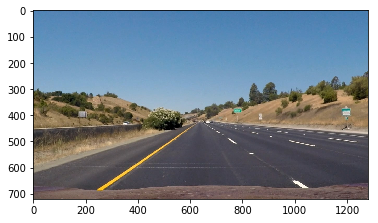

In [12]:
image = cv2.imread("test_images\\straight_lines1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("shape of image object = ", image.shape)
print("type of image object = ", type(image))
showImg(image)   

## Validate pipeline on test images

Use test images to validate the pipeline.


Inside reset


C:\Users\ADMIN\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


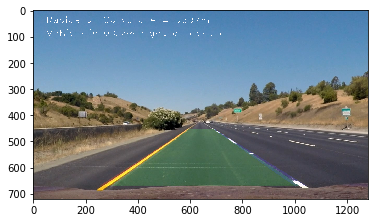

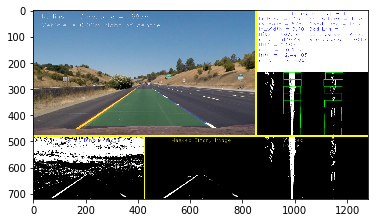

Pair of lanes detected =  1


In [20]:
reset_lanes = True
detected_lines = []

drive_log = open("driveLog.txt","w") 
drive_log.write("Driver's Log -------------------\n")

# use n for normal, c for challenge and h for harder
terrain_type = 'n'

# Caliberate Camera
#mtx, dist = caliberate_camera()

# Get perspective
#perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
#baseline_lane_width = compute_lane_width()

image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
marked_img = lane_marker_pipeline(image)
showImg(marked_img)
combined_imgs = img_collage(marked_img)
showImg(combined_imgs)
combined_imgs = cv2.cvtColor(combined_imgs, cv2.COLOR_RGB2BGR)
cv2.imwrite('text_test.jpg',combined_imgs)
drive_log.close()

"""
images = glob.glob('test_images/test1*')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    marked_img = lane_marker_pipeline(image)
    showImg(marked_img)
    combined_imgs = img_collage(marked_img)
    showImg(combined_imgs)
    combined_imgs = cv2.cvtColor(combined_imgs, cv2.COLOR_RGB2BGR)
    cv2.imwrite('text_test.jpg',combined_imgs)
""" 
print("Pair of lanes detected = ", len(detected_lines))
    

## Test lane finding pipeline on Videos

This section reads the clips from the video, passes them to the pipeline and creates a video out of the pipeline outputs



In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [25]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # Calling pipeline that will return the final output (image where lines are drawn on lanes)
        
    result = lane_marker_pipeline(image)
    result = img_collage(result)

    return result

## Project Video

Applying lane marking pipeline on project video.

In [ ]:
# Initialize variables
reset_lanes = True
detected_lines = []

drive_log = open("driveLog.txt","w") 
drive_log.write("Driver's Log -------------------\n")

# use n for normal, c for challenge and h for harder
terrain_type = 'n'

# Caliberate Camera
mtx, dist = caliberate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

project_video_output = 'project_video_output.mp4'
#clip1 = VideoFileClip("P2.mp4")
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)
print("Number of frames = ", len(detected_lines))
drive_log.close()

## Challenge Video

Applying lane marking pipeline on challenge video.

Chess board shape =  (1280, 720)
Camera caliberated.  mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]


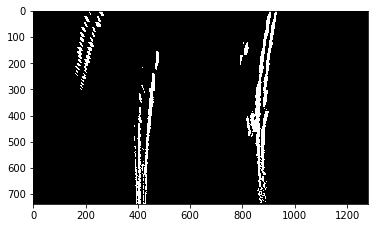

(1280,)
Baseline mid, left, center =  640 407 864
Baeline Lane width in pixels =  457
Inside reset
[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4



  5%|██████████▏                                                                                                                                                                                           | 25/485 [00:08<02:41,  2.85it/s]

@ 26  > Continuity check failed - right curve variation high :  798.650940467 7713.56589554



  5%|██████████▌                                                                                                                                                                                           | 26/485 [00:09<02:42,  2.82it/s]

@ 27  > Continuity check failed - right curve variation high :  599.798916178 7713.56589554



  6%|███████████                                                                                                                                                                                           | 27/485 [00:09<02:43,  2.81it/s]

@ 28  > Continuity check failed - right curve variation high :  504.092607491 7713.56589554



  6%|███████████▍                                                                                                                                                                                          | 28/485 [00:09<02:43,  2.79it/s]

@ 29  > Continuity check failed - right curve variation high :  487.95192685 7713.56589554



  6%|███████████▊                                                                                                                                                                                          | 29/485 [00:10<02:45,  2.75it/s]

@ 30  > Continuity check failed - right curve variation high :  461.718352884 7713.56589554



  6%|████████████▏                                                                                                                                                                                         | 30/485 [00:10<02:45,  2.75it/s]

@ 31  > Continuity check failed - right curve variation high :  389.36039997 7713.56589554



  6%|████████████▋                                                                                                                                                                                         | 31/485 [00:10<02:45,  2.74it/s]

Inside reset



  8%|███████████████▉                                                                                                                                                                                      | 39/485 [00:13<02:34,  2.89it/s]

@ 40  > curve check failure :  433.849650218 21603.3407799



  8%|████████████████▎                                                                                                                                                                                     | 40/485 [00:14<02:36,  2.85it/s]

@ 41  > 2nd order coefficient similarity failure :  0.000231359609784 -0.000269039325871



  8%|████████████████▋                                                                                                                                                                                     | 41/485 [00:14<02:37,  2.82it/s]

@ 42  > 2nd order coefficient similarity failure :  0.000264256751739 -0.000441864276697



  9%|█████████████████▏                                                                                                                                                                                    | 42/485 [00:14<02:38,  2.79it/s]

@ 43  > 2nd order coefficient similarity failure :  0.000160075761914 -0.00043164564712



  9%|█████████████████▌                                                                                                                                                                                    | 43/485 [00:15<02:39,  2.78it/s]

@ 44  > Continuity check failed - right curve variation high :  268.258666672 2422.61959206



  9%|█████████████████▉                                                                                                                                                                                    | 44/485 [00:15<02:40,  2.75it/s]

@ 45  > Continuity check failed - right curve variation high :  294.302694324 2422.61959206



  9%|██████████████████▎                                                                                                                                                                                   | 45/485 [00:15<02:39,  2.76it/s]

Inside reset



 10%|███████████████████▌                                                                                                                                                                                  | 48/485 [00:17<02:33,  2.84it/s]

@ 49  > 2nd order coefficient similarity failure :  -0.000243288793163 0.000333101930974



 10%|████████████████████                                                                                                                                                                                  | 49/485 [00:17<02:34,  2.83it/s]

@ 50  > 2nd order coefficient similarity failure :  -0.000303839897339 0.000330932183086



 10%|████████████████████▍                                                                                                                                                                                 | 50/485 [00:17<02:35,  2.79it/s]

@ 51  > 2nd order coefficient similarity failure :  -0.000306976487597 0.0003335540109



 11%|████████████████████▊                                                                                                                                                                                 | 51/485 [00:18<02:36,  2.78it/s]

@ 52  > 2nd order coefficient similarity failure :  -0.000322014524615 0.000413464323995



 11%|█████████████████████▏                                                                                                                                                                                | 52/485 [00:18<02:36,  2.77it/s]

@ 53  > 2nd order coefficient similarity failure :  -0.000429596803152 0.000485404177318



 11%|█████████████████████▋                                                                                                                                                                                | 53/485 [00:18<02:35,  2.77it/s]

@ 54  > 2nd order coefficient similarity failure :  -0.000479183213994 0.00044481629382



 11%|██████████████████████                                                                                                                                                                                | 54/485 [00:19<02:34,  2.78it/s]

Inside reset
@ 55  > 2nd order coefficient similarity failure :  -0.000177752048005 0.000545874348116



 11%|██████████████████████▍                                                                                                                                                                               | 55/485 [00:19<02:36,  2.74it/s]

Inside reset
@ 56  > 2nd order coefficient similarity failure :  -0.000201539696798 0.000572294285087



 12%|██████████████████████▊                                                                                                                                                                               | 56/485 [00:19<02:38,  2.70it/s]

Inside reset
@ 57  > 1st order coefficient similarity failure :  0.120966510623 -0.518177238995



 12%|███████████████████████▎                                                                                                                                                                              | 57/485 [00:20<02:39,  2.68it/s]

Inside reset
@ 58  > 1st order coefficient similarity failure :  0.0991215139716 -0.514269858083



 12%|███████████████████████▋                                                                                                                                                                              | 58/485 [00:20<02:40,  2.66it/s]

Inside reset



 12%|████████████████████████                                                                                                                                                                              | 59/485 [00:21<02:38,  2.69it/s]

@ 60  > 2nd order coefficient similarity failure :  0.000702418391118 0.000178212657145



 14%|███████████████████████████▎                                                                                                                                                                          | 67/485 [00:23<02:25,  2.87it/s]

@ 68  > lane width failure :  4.22148915045



 14%|███████████████████████████▊                                                                                                                                                                          | 68/485 [00:24<02:26,  2.84it/s]

@ 69  > lane width failure :  4.22148915045



 14%|████████████████████████████▏                                                                                                                                                                         | 69/485 [00:24<02:26,  2.83it/s]

@ 70  > lane width failure :  4.22148915045



 14%|████████████████████████████▌                                                                                                                                                                         | 70/485 [00:24<02:27,  2.81it/s]

@ 71  > lane width failure :  4.22148915045



 15%|████████████████████████████▉                                                                                                                                                                         | 71/485 [00:25<02:29,  2.78it/s]

@ 72  > lane width failure :  4.22148915045



 15%|█████████████████████████████▍                                                                                                                                                                        | 72/485 [00:25<02:28,  2.78it/s]

@ 73  > lane width failure :  4.22148915045



 15%|█████████████████████████████▊                                                                                                                                                                        | 73/485 [00:26<02:27,  2.78it/s]

Inside reset
@ 74  > lane width failure :  4.55010940919



 15%|██████████████████████████████▏                                                                                                                                                                       | 74/485 [00:26<02:30,  2.73it/s]

Inside reset
@ 75  > lane width failure :  4.52582056893



 15%|██████████████████████████████▌                                                                                                                                                                       | 75/485 [00:26<02:31,  2.70it/s]

Inside reset
@ 76  > lane width failure :  4.51772428884



 16%|███████████████████████████████                                                                                                                                                                       | 76/485 [00:27<02:32,  2.68it/s]

Inside reset
@ 77  > lane width failure :  4.68774617068



 16%|███████████████████████████████▍                                                                                                                                                                      | 77/485 [00:27<02:33,  2.66it/s]

Inside reset
@ 78  > lane width failure :  4.65536105033



 16%|███████████████████████████████▊                                                                                                                                                                      | 78/485 [00:27<02:33,  2.65it/s]

Inside reset
@ 79  > lane width failure :  4.6067833698



 16%|████████████████████████████████▎                                                                                                                                                                     | 79/485 [00:28<02:33,  2.65it/s]

Inside reset
@ 80  > lane width failure :  4.55820568928



 16%|████████████████████████████████▋                                                                                                                                                                     | 80/485 [00:28<02:33,  2.64it/s]

Inside reset
@ 81  > lane width failure :  4.51772428884



 17%|█████████████████████████████████                                                                                                                                                                     | 81/485 [00:29<02:33,  2.64it/s]

Inside reset
@ 82  > lane width failure :  4.59868708972



 17%|█████████████████████████████████▍                                                                                                                                                                    | 82/485 [00:29<02:32,  2.65it/s]

Inside reset
@ 83  > lane width failure :  4.62297592998



 17%|█████████████████████████████████▉                                                                                                                                                                    | 83/485 [00:29<02:31,  2.65it/s]

Inside reset
@ 84  > lane width failure :  4.6067833698



 17%|██████████████████████████████████▎                                                                                                                                                                   | 84/485 [00:30<02:31,  2.65it/s]

Inside reset
@ 85  > lane width failure :  4.57439824945



 18%|██████████████████████████████████▋                                                                                                                                                                   | 85/485 [00:30<02:31,  2.64it/s]

Inside reset
@ 86  > lane width failure :  4.55010940919



 18%|███████████████████████████████████                                                                                                                                                                   | 86/485 [00:30<02:33,  2.60it/s]

Inside reset
@ 87  > lane width failure :  4.37199124726



 18%|███████████████████████████████████▌                                                                                                                                                                  | 87/485 [00:31<02:32,  2.60it/s]

Inside reset
@ 88  > lane width failure :  4.4124726477



 18%|███████████████████████████████████▉                                                                                                                                                                  | 88/485 [00:31<02:32,  2.61it/s]

Inside reset
@ 89  > lane width failure :  4.64726477024



 18%|████████████████████████████████████▎                                                                                                                                                                 | 89/485 [00:32<02:31,  2.61it/s]

Inside reset
@ 90  > lane width failure :  4.64726477024



 19%|████████████████████████████████████▋                                                                                                                                                                 | 90/485 [00:32<02:31,  2.60it/s]

Inside reset
@ 91  > lane width failure :  4.59868708972



 19%|█████████████████████████████████████▏                                                                                                                                                                | 91/485 [00:32<02:31,  2.60it/s]

Inside reset
@ 92  > lane width failure :  4.72013129103



 19%|█████████████████████████████████████▌                                                                                                                                                                | 92/485 [00:33<02:30,  2.61it/s]

Inside reset
@ 93  > lane width failure :  4.56630196937



 19%|█████████████████████████████████████▉                                                                                                                                                                | 93/485 [00:33<02:31,  2.60it/s]

Inside reset
@ 94  > lane width failure :  4.55820568928



 19%|██████████████████████████████████████▍                                                                                                                                                               | 94/485 [00:34<02:29,  2.61it/s]

Inside reset
@ 95  > lane width failure :  4.59868708972



 20%|██████████████████████████████████████▊                                                                                                                                                               | 95/485 [00:34<02:29,  2.61it/s]

Inside reset
@ 96  > lane width failure :  4.52582056893



 20%|███████████████████████████████████████▏                                                                                                                                                              | 96/485 [00:34<02:28,  2.61it/s]

Inside reset
@ 97  > lane width failure :  4.38008752735



 20%|███████████████████████████████████████▌                                                                                                                                                              | 97/485 [00:35<02:28,  2.61it/s]

Inside reset
@ 98  > lane width failure :  4.33150984683



 20%|████████████████████████████████████████                                                                                                                                                              | 98/485 [00:35<02:28,  2.61it/s]

Inside reset
@ 99  > lane width failure :  4.27483588621



 20%|████████████████████████████████████████▍                                                                                                                                                             | 99/485 [00:35<02:28,  2.60it/s]

Inside reset
@ 100  > lane width failure :  4.30722100656



 21%|████████████████████████████████████████▌                                                                                                                                                            | 100/485 [00:36<02:29,  2.57it/s]

Inside reset
@ 101  > lane width failure :  4.38818380744



 21%|█████████████████████████████████████████                                                                                                                                                            | 101/485 [00:36<02:28,  2.59it/s]

Inside reset
@ 102  > lane width failure :  4.45295404814



 21%|█████████████████████████████████████████▍                                                                                                                                                           | 102/485 [00:37<02:27,  2.59it/s]

Inside reset
@ 103  > lane width failure :  4.61487964989



 21%|█████████████████████████████████████████▊                                                                                                                                                           | 103/485 [00:37<02:26,  2.61it/s]

Inside reset
@ 104  > lane width failure :  4.70393873085



 21%|██████████████████████████████████████████▏                                                                                                                                                          | 104/485 [00:37<02:25,  2.62it/s]

Inside reset
@ 105  > 1st order coefficient similarity failure :  -0.0244932227808 -0.682699968509



 22%|██████████████████████████████████████████▋                                                                                                                                                          | 105/485 [00:38<02:25,  2.61it/s]

Inside reset
@ 106  > 1st order coefficient similarity failure :  -0.0664425769491 -0.748815753908



 22%|███████████████████████████████████████████                                                                                                                                                          | 106/485 [00:38<02:25,  2.61it/s]

Inside reset



 22%|████████████████████████████████████████████▎                                                                                                                                                        | 109/485 [00:39<02:15,  2.77it/s]

@ 110  > 2nd order coefficient similarity failure :  0.000717623391387 0.000207532868127



 25%|████████████████████████████████████████████████▎                                                                                                                                                    | 119/485 [00:43<02:05,  2.91it/s]

@ 120  > Continuity check failed - right curve variation high :  327.70529885 1559.17539376



 25%|█████████████████████████████████████████████████▉                                                                                                                                                   | 123/485 [00:44<02:04,  2.92it/s]

@ 124  > 1st order coefficient similarity failure :  0.118403017692 -0.453319273732



 26%|██████████████████████████████████████████████████▊                                                                                                                                                  | 125/485 [00:45<02:04,  2.90it/s]

@ 126  > 2nd order coefficient similarity failure :  -0.000727288355474 -0.000154793046087



 26%|███████████████████████████████████████████████████▏                                                                                                                                                 | 126/485 [00:45<02:06,  2.84it/s]

@ 127  > 2nd order coefficient similarity failure :  -0.000829051039531 -0.00013964370045



 26%|███████████████████████████████████████████████████▌                                                                                                                                                 | 127/485 [00:45<02:06,  2.83it/s]

@ 128  > 2nd order coefficient similarity failure :  -0.0017644677376 -6.0819940422e-05



 26%|███████████████████████████████████████████████████▉                                                                                                                                                 | 128/485 [00:46<02:06,  2.81it/s]

@ 129  > 2nd order coefficient similarity failure :  -0.00306757993958 -0.00105699613897



 27%|████████████████████████████████████████████████████▍                                                                                                                                                | 129/485 [00:46<02:06,  2.81it/s]

@ 130  > 2nd order coefficient similarity failure :  -0.00843020266948 -1.87751632022e-05



 27%|████████████████████████████████████████████████████▊                                                                                                                                                | 130/485 [00:47<02:07,  2.79it/s]

@ 131  > 2nd order coefficient similarity failure :  0.056822200451 0.00042576414498



 27%|█████████████████████████████████████████████████████▏                                                                                                                                               | 131/485 [00:47<02:06,  2.79it/s]

Inside reset
@ 132  > 2nd order coefficient similarity failure :  -0.0408903185895 0.00156981715061



 27%|█████████████████████████████████████████████████████▌                                                                                                                                               | 132/485 [00:47<02:08,  2.74it/s]

Inside reset
@ 133  > curve check failure :  65051.6597103 35997.0924181



 27%|██████████████████████████████████████████████████████                                                                                                                                               | 133/485 [00:48<02:09,  2.72it/s]

Inside reset
@ 134  > low pass failure :  9 22



 28%|██████████████████████████████████████████████████████▍                                                                                                                                              | 134/485 [00:48<02:10,  2.69it/s]

Inside reset
@ 135  > low pass failure :  8 1047



 28%|██████████████████████████████████████████████████████▊                                                                                                                                              | 135/485 [00:48<02:10,  2.68it/s]

Inside reset
@ 136  > low pass failure :  8 1808



 28%|███████████████████████████████████████████████████████▏                                                                                                                                             | 136/485 [00:49<02:10,  2.67it/s]

Inside reset
@ 137  > lane width failure :  2.17789934354



 28%|███████████████████████████████████████████████████████▋                                                                                                                                             | 137/485 [00:49<02:10,  2.67it/s]

Inside reset
@ 138  > lane width failure :  2.25886214442



 28%|████████████████████████████████████████████████████████                                                                                                                                             | 138/485 [00:50<02:10,  2.66it/s]

Inside reset
@ 139  > lane width failure :  7.00328227571



 29%|████████████████████████████████████████████████████████▍                                                                                                                                            | 139/485 [00:50<02:10,  2.66it/s]

Inside reset
@ 140  > 2nd order coefficient similarity failure :  -0.00106588349657 0.00030923993308



 29%|████████████████████████████████████████████████████████▊                                                                                                                                            | 140/485 [00:50<02:09,  2.67it/s]

Inside reset



 29%|█████████████████████████████████████████████████████████▎                                                                                                                                           | 141/485 [00:51<02:08,  2.68it/s]

@ 142  > 2nd order coefficient similarity failure :  -0.000362588077306 0.000391479942423



 29%|█████████████████████████████████████████████████████████▋                                                                                                                                           | 142/485 [00:51<02:06,  2.72it/s]

@ 143  > 1st order coefficient similarity failure :  0.0809286551052 -0.355613582274



 29%|██████████████████████████████████████████████████████████                                                                                                                                           | 143/485 [00:51<02:04,  2.74it/s]

@ 144  > 1st order coefficient similarity failure :  -0.0312760543552 -0.831629757713



 30%|██████████████████████████████████████████████████████████▍                                                                                                                                          | 144/485 [00:52<02:04,  2.73it/s]

@ 145  > 1st order coefficient similarity failure :  0.0145181205906 -0.75926703532



 30%|██████████████████████████████████████████████████████████▉                                                                                                                                          | 145/485 [00:52<02:03,  2.75it/s]

@ 146  > 2nd order coefficient similarity failure :  -1.58493988694e-05 0.000520154715086



 30%|███████████████████████████████████████████████████████████▎                                                                                                                                         | 146/485 [00:52<02:04,  2.72it/s]

@ 147  > 1st order coefficient similarity failure :  0.0523576691308 -0.442310631009



 30%|███████████████████████████████████████████████████████████▋                                                                                                                                         | 147/485 [00:53<02:03,  2.74it/s]

Inside reset
@ 148  > lane width failure :  4.92253829322



 31%|████████████████████████████████████████████████████████████                                                                                                                                         | 148/485 [00:53<02:05,  2.69it/s]

Inside reset
@ 149  > lane width failure :  4.87396061269



 31%|████████████████████████████████████████████████████████████▌                                                                                                                                        | 149/485 [00:54<02:05,  2.67it/s]

Inside reset
@ 150  > lane width failure :  4.95492341357



 31%|████████████████████████████████████████████████████████████▉                                                                                                                                        | 150/485 [00:54<02:06,  2.65it/s]

Inside reset
@ 151  > lane width failure :  4.71203501094



 31%|█████████████████████████████████████████████████████████████▎                                                                                                                                       | 151/485 [00:54<02:06,  2.65it/s]

Inside reset
@ 152  > lane width failure :  4.64726477024



 31%|█████████████████████████████████████████████████████████████▋                                                                                                                                       | 152/485 [00:55<02:05,  2.65it/s]

Inside reset
@ 153  > lane width failure :  4.59868708972



 32%|██████████████████████████████████████████████████████████████▏                                                                                                                                      | 153/485 [00:55<02:05,  2.64it/s]

Inside reset
@ 154  > lane width failure :  4.72013129103



 32%|██████████████████████████████████████████████████████████████▌                                                                                                                                      | 154/485 [00:56<02:07,  2.61it/s]

Inside reset
@ 155  > 1st order coefficient similarity failure :  0.0256286642436 -0.430892720437



 32%|██████████████████████████████████████████████████████████████▉                                                                                                                                      | 155/485 [00:56<02:06,  2.61it/s]

Inside reset
@ 156  > 1st order coefficient similarity failure :  0.0487290493273 -0.408017952248



 32%|███████████████████████████████████████████████████████████████▎                                                                                                                                     | 156/485 [00:56<02:06,  2.61it/s]

Inside reset
@ 157  > 1st order coefficient similarity failure :  0.0718671581304 -0.402507186874



 32%|███████████████████████████████████████████████████████████████▊                                                                                                                                     | 157/485 [00:57<02:06,  2.60it/s]

Inside reset
@ 158  > 1st order coefficient similarity failure :  -0.0232171276909 -0.477515507086



 33%|████████████████████████████████████████████████████████████████▏                                                                                                                                    | 158/485 [00:57<02:05,  2.60it/s]

Inside reset
@ 159  > 1st order coefficient similarity failure :  -0.0433524212399 -0.488661241561



 33%|████████████████████████████████████████████████████████████████▌                                                                                                                                    | 159/485 [00:57<02:05,  2.60it/s]

Inside reset
@ 160  > 1st order coefficient similarity failure :  -0.0328873794777 -0.501071008134



 33%|████████████████████████████████████████████████████████████████▉                                                                                                                                    | 160/485 [00:58<02:05,  2.59it/s]

Inside reset



 33%|█████████████████████████████████████████████████████████████████▊                                                                                                                                   | 162/485 [00:59<01:59,  2.70it/s]

@ 163  > Continuity check failed - right curve variation high :  671.315129232 3463.08924983



 34%|██████████████████████████████████████████████████████████████████▏                                                                                                                                  | 163/485 [00:59<01:58,  2.72it/s]

@ 164  > Continuity check failed - right curve variation high :  376.757641702 3463.08924983



 34%|██████████████████████████████████████████████████████████████████▌                                                                                                                                  | 164/485 [00:59<01:58,  2.71it/s]

@ 165  > 1st order coefficient similarity failure :  0.0726808432662 -0.320631928639



 34%|███████████████████████████████████████████████████████████████████                                                                                                                                  | 165/485 [01:00<01:57,  2.72it/s]

@ 166  > 1st order coefficient similarity failure :  0.0912504198279 -0.296247117251



 34%|███████████████████████████████████████████████████████████████████▍                                                                                                                                 | 166/485 [01:00<01:56,  2.74it/s]

@ 167  > 1st order coefficient similarity failure :  0.122600306637 -0.303362521413



 34%|███████████████████████████████████████████████████████████████████▊                                                                                                                                 | 167/485 [01:00<01:56,  2.73it/s]

@ 168  > 1st order coefficient similarity failure :  0.0990017228109 -0.348415795357



 35%|████████████████████████████████████████████████████████████████████▏                                                                                                                                | 168/485 [01:01<01:56,  2.71it/s]

Inside reset
@ 169  > 1st order coefficient similarity failure :  0.104519369296 -0.362579261387



 35%|████████████████████████████████████████████████████████████████████▋                                                                                                                                | 169/485 [01:01<01:57,  2.68it/s]

Inside reset
@ 170  > 1st order coefficient similarity failure :  0.105586369141 -0.443160444148



 35%|█████████████████████████████████████████████████████████████████████                                                                                                                                | 170/485 [01:02<01:58,  2.66it/s]

Inside reset
@ 171  > 1st order coefficient similarity failure :  0.0885661230451 -0.436443785126



 35%|█████████████████████████████████████████████████████████████████████▍                                                                                                                               | 171/485 [01:02<01:58,  2.65it/s]

Inside reset
@ 172  > 1st order coefficient similarity failure :  0.0733908106408 -0.463173689052



 35%|█████████████████████████████████████████████████████████████████████▊                                                                                                                               | 172/485 [01:02<01:58,  2.64it/s]

Inside reset
@ 173  > 1st order coefficient similarity failure :  0.0818457105424 -0.503261202157



 36%|██████████████████████████████████████████████████████████████████████▎                                                                                                                              | 173/485 [01:03<01:58,  2.64it/s]

Inside reset



 36%|███████████████████████████████████████████████████████████████████████▉                                                                                                                             | 177/485 [01:04<01:51,  2.77it/s]

@ 178  > 1st order coefficient similarity failure :  0.106746382751 -0.303433612603



 37%|████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 178/485 [01:04<01:50,  2.77it/s]

@ 179  > 1st order coefficient similarity failure :  0.0682891409107 -0.339342599821



 37%|████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 179/485 [01:05<01:51,  2.76it/s]

@ 180  > 1st order coefficient similarity failure :  0.0679203417187 -0.358380882073



 37%|█████████████████████████████████████████████████████████████████████████                                                                                                                            | 180/485 [01:05<01:50,  2.76it/s]

@ 181  > 1st order coefficient similarity failure :  0.147173293421 -0.334526468723



 37%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 181/485 [01:06<01:50,  2.75it/s]

@ 182  > 1st order coefficient similarity failure :  0.0652510624029 -0.36574167109



 38%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 182/485 [01:06<01:49,  2.76it/s]

@ 183  > 1st order coefficient similarity failure :  0.00892316590155 -0.392100989526



 38%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 183/485 [01:06<01:49,  2.75it/s]

Inside reset
@ 184  > 1st order coefficient similarity failure :  0.105279368905 -0.416146547857



 38%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 184/485 [01:07<01:51,  2.70it/s]

Inside reset
@ 185  > 1st order coefficient similarity failure :  0.103745246246 -0.414084442992



 38%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 185/485 [01:07<01:52,  2.66it/s]

Inside reset
@ 186  > 1st order coefficient similarity failure :  0.0648492715657 -0.459778302834



 38%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 186/485 [01:07<01:52,  2.65it/s]

Inside reset
@ 187  > 1st order coefficient similarity failure :  0.0286072004364 -0.62049805699



 39%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 187/485 [01:08<01:53,  2.63it/s]

Inside reset



 40%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 196/485 [01:11<01:40,  2.87it/s]

@ 197  > 1st order coefficient similarity failure :  0.0162509285349 -0.341061321306



 41%|████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 197/485 [01:11<01:41,  2.84it/s]

@ 198  > 1st order coefficient similarity failure :  0.0356104024638 -0.382907274839



 41%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 198/485 [01:12<01:41,  2.82it/s]

@ 199  > 1st order coefficient similarity failure :  0.00794024462036 -0.467868799852



 42%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 202/485 [01:13<01:40,  2.82it/s]

@ 203  > Continuity check failed - right curve variation high :  381.596802743 6556.50347741



 42%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 203/485 [01:13<01:40,  2.80it/s]

@ 204  > Continuity check failed - right curve variation high :  281.795210168 6556.50347741



 42%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 204/485 [01:14<01:40,  2.79it/s]

@ 205  > Continuity check failed - right curve variation high :  296.98297034 6556.50347741



 42%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 205/485 [01:14<01:40,  2.78it/s]

@ 206  > Continuity check failed - right curve variation high :  298.51670635 6556.50347741



 42%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 206/485 [01:15<01:41,  2.75it/s]

@ 207  > Continuity check failed - right curve variation high :  269.555506564 6556.50347741



 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 207/485 [01:15<01:40,  2.75it/s]

@ 208  > Continuity check failed - right curve variation high :  248.778369832 6556.50347741



 43%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 208/485 [01:15<01:41,  2.74it/s]

Inside reset



 43%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 209/485 [01:16<01:40,  2.73it/s]

@ 210  > 1st order coefficient similarity failure :  -0.057092447228 -0.440513869852



 43%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 210/485 [01:16<01:40,  2.75it/s]

@ 211  > 1st order coefficient similarity failure :  -0.045378989432 -0.408616187194



 46%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 224/485 [01:21<01:30,  2.87it/s]

@ 225  > 1st order coefficient similarity failure :  -0.116928105687 -0.505468705352



 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 250/485 [01:30<01:22,  2.86it/s]

@ 251  > 1st order coefficient similarity failure :  -0.0251313654407 -0.445529479739



 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 251/485 [01:30<01:24,  2.78it/s]

@ 252  > 1st order coefficient similarity failure :  -0.0510974626954 -0.415666072124



 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 252/485 [01:31<01:24,  2.76it/s]

@ 253  > 1st order coefficient similarity failure :  -0.0411368837513 -0.429155869824



 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 253/485 [01:31<01:24,  2.75it/s]

@ 254  > 1st order coefficient similarity failure :  -0.00914650006546 -0.393098730726



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 266/485 [01:36<01:16,  2.88it/s]

@ 267  > 1st order coefficient similarity failure :  -0.172300130514 -0.538308593087



 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 269/485 [01:37<01:15,  2.86it/s]

@ 270  > curve check failure :  233.956925728 30457.5309591



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 294/485 [01:45<01:06,  2.89it/s]

@ 295  > 1st order coefficient similarity failure :  -0.0745620595843 -0.457888093604



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 295/485 [01:46<01:06,  2.84it/s]

@ 296  > 1st order coefficient similarity failure :  -0.0262349069605 -0.456481872553



 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 302/485 [01:48<01:03,  2.87it/s]

@ 303  > 1st order coefficient similarity failure :  0.0491262301977 -0.322696165007



 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 307/485 [01:50<01:02,  2.87it/s]

@ 308  > 1st order coefficient similarity failure :  -0.0157299051309 -0.428286965974



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 308/485 [01:50<01:02,  2.83it/s]

@ 309  > 1st order coefficient similarity failure :  -0.0326593754384 -0.430791032104



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 309/485 [01:51<01:02,  2.82it/s]

@ 310  > 1st order coefficient similarity failure :  -0.0292501699683 -0.439832676926



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 310/485 [01:51<01:02,  2.78it/s]

@ 311  > left and right curves similarity failure :  317.378393637 14110.2146942



 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 321/485 [01:55<00:57,  2.87it/s]

@ 322  > 1st order coefficient similarity failure :  -0.00548215859745 -0.376944164469



 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 322/485 [01:55<00:57,  2.85it/s]

@ 323  > 1st order coefficient similarity failure :  -0.00747048250459 -0.358848107416



 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 327/485 [01:57<00:55,  2.83it/s]

@ 328  > lane width failure :  4.2134172457



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 328/485 [01:57<00:55,  2.82it/s]

@ 329  > lane width failure :  4.2134172457



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 329/485 [01:58<00:55,  2.81it/s]

@ 330  > lane width failure :  4.2134172457



 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 330/485 [01:58<00:55,  2.79it/s]

@ 331  > lane width failure :  4.2134172457



 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 331/485 [01:58<00:55,  2.79it/s]

@ 332  > lane width failure :  4.2134172457



 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 332/485 [01:59<00:55,  2.77it/s]

@ 333  > lane width failure :  4.2134172457



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 333/485 [01:59<00:54,  2.77it/s]

Inside reset
@ 334  > left and right curves similarity failure :  11513.6958283 337.744822219



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 334/485 [02:00<00:55,  2.71it/s]

Inside reset
@ 335  > left and right curves similarity failure :  14722.8803563 353.324153946



 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 335/485 [02:00<00:56,  2.67it/s]

Inside reset
@ 336  > 1st order coefficient similarity failure :  0.160565017975 -0.3126965867



 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 336/485 [02:00<00:56,  2.65it/s]

Inside reset



 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 338/485 [02:01<00:53,  2.72it/s]

@ 339  > Continuity check failed - right curve variation high :  1431.26519622 5847.44577242



 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 339/485 [02:01<00:53,  2.73it/s]

@ 340  > Continuity check failed - right curve variation high :  284.490729797 5847.44577242



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 340/485 [02:02<00:53,  2.73it/s]

@ 341  > Continuity check failed - right curve variation high :  328.807688437 5847.44577242



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 341/485 [02:02<00:53,  2.71it/s]

@ 342  > Continuity check failed - right curve variation high :  368.718669239 5847.44577242



 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 342/485 [02:03<00:52,  2.72it/s]

@ 343  > Continuity check failed - right curve variation high :  354.356073918 5847.44577242



 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 343/485 [02:03<00:52,  2.72it/s]

@ 344  > Continuity check failed - right curve variation high :  404.135897497 5847.44577242



 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 344/485 [02:03<00:51,  2.73it/s]

Inside reset



 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 353/485 [02:06<00:46,  2.87it/s]

@ 354  > Continuity check failed - right curve variation high :  447.34766078 1868.65109095



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 359/485 [02:09<00:44,  2.86it/s]

@ 360  > 1st order coefficient similarity failure :  0.155059778654 -0.218744950109



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 360/485 [02:09<00:44,  2.82it/s]

@ 361  > 1st order coefficient similarity failure :  0.201509063581 -0.199689157367



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 361/485 [02:09<00:44,  2.79it/s]

@ 362  > 1st order coefficient similarity failure :  0.171892644806 -0.179564743957



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 366/485 [02:11<00:42,  2.82it/s]

@ 367  > Continuity check failed - right curve variation high :  375.131175797 1774.54145665



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 367/485 [02:11<00:42,  2.80it/s]

@ 368  > Continuity check failed - right curve variation high :  383.773198609 1774.54145665



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 368/485 [02:12<00:42,  2.78it/s]

@ 369  > Continuity check failed - right curve variation high :  419.056995883 1774.54145665



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 369/485 [02:12<00:42,  2.76it/s]

@ 370  > Continuity check failed - right curve variation high :  434.858731572 1774.54145665



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 370/485 [02:13<00:41,  2.74it/s]

@ 371  > Continuity check failed - right curve variation high :  442.578536121 1774.54145665



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 371/485 [02:13<00:41,  2.73it/s]

@ 372  > 1st order coefficient similarity failure :  0.209649400271 -0.145668432136



 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 372/485 [02:13<00:41,  2.73it/s]

Inside reset
@ 373  > 1st order coefficient similarity failure :  0.20447919136 -0.204692654368



 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 373/485 [02:14<00:41,  2.68it/s]

Inside reset
@ 374  > 1st order coefficient similarity failure :  0.216779334715 -0.20294863433



 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 374/485 [02:14<00:42,  2.64it/s]

Inside reset
@ 375  > 1st order coefficient similarity failure :  0.191443358583 -0.212814822428



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 375/485 [02:14<00:41,  2.63it/s]

Inside reset
@ 376  > 1st order coefficient similarity failure :  0.165173054645 -0.203112834978



 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 376/485 [02:15<00:41,  2.62it/s]

Inside reset
@ 377  > 1st order coefficient similarity failure :  0.169513270795 -0.204626295224



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 377/485 [02:15<00:41,  2.61it/s]

Inside reset
@ 378  > 1st order coefficient similarity failure :  0.1770865012 -0.232412942628



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 378/485 [02:16<00:41,  2.58it/s]

Inside reset
@ 379  > 1st order coefficient similarity failure :  0.230231707489 -0.247297830853



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 379/485 [02:16<00:41,  2.58it/s]

Inside reset



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 380/485 [02:16<00:40,  2.61it/s]

@ 381  > Continuity check failed - right curve variation high :  731.354076478 5683.00372055



 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 381/485 [02:17<00:39,  2.64it/s]

@ 382  > curve check failure :  1158.32411909 27090.3054767



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 382/485 [02:17<00:38,  2.67it/s]

@ 383  > Continuity check failed - right curve variation high :  886.169498596 5683.00372055



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 383/485 [02:18<00:37,  2.70it/s]

@ 384  > 1st order coefficient similarity failure :  0.396325096179 -0.118468986633



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 384/485 [02:18<00:37,  2.70it/s]

@ 385  > 1st order coefficient similarity failure :  0.35180939628 -0.125734005025



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 385/485 [02:18<00:36,  2.71it/s]

@ 386  > 1st order coefficient similarity failure :  0.301110253982 -0.229056771691



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 386/485 [02:19<00:36,  2.71it/s]

Inside reset
@ 387  > 1st order coefficient similarity failure :  0.278971812253 -0.247706651745



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 387/485 [02:19<00:36,  2.67it/s]

Inside reset
@ 388  > 1st order coefficient similarity failure :  0.455155282744 -0.279931034738



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 388/485 [02:19<00:36,  2.64it/s]

Inside reset
@ 389  > 2nd order coefficient similarity failure :  -0.000243156807084 0.000340639088629



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 389/485 [02:20<00:37,  2.58it/s]

Inside reset



 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 391/485 [02:20<00:34,  2.72it/s]

@ 392  > 1st order coefficient similarity failure :  0.00860463416457 -0.34330743496



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 393/485 [02:21<00:33,  2.78it/s]

@ 394  > 1st order coefficient similarity failure :  0.572917639588 0.0104080221743



 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 394/485 [02:22<00:32,  2.76it/s]

@ 395  > 1st order coefficient similarity failure :  0.552264046468 0.0511258516692



 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 395/485 [02:22<00:32,  2.75it/s]

@ 396  > curve check failure :  251.549991246 57130.9327798



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 396/485 [02:22<00:32,  2.75it/s]

@ 397  > 2nd order coefficient similarity failure :  -0.000356808572007 0.000189670490007



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 397/485 [02:23<00:32,  2.74it/s]

@ 398  > 1st order coefficient similarity failure :  0.567740438316 -0.143515700977



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 398/485 [02:23<00:32,  2.70it/s]

@ 399  > 1st order coefficient similarity failure :  0.433738940997 -0.178868030948



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 399/485 [02:23<00:31,  2.73it/s]

Inside reset



 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 414/485 [02:29<00:24,  2.90it/s]

@ 415  > 1st order coefficient similarity failure :  0.122049718815 -0.330595774796



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 415/485 [02:29<00:24,  2.87it/s]

@ 416  > 1st order coefficient similarity failure :  0.152071710983 -0.30996303444



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 416/485 [02:29<00:24,  2.83it/s]

@ 417  > 1st order coefficient similarity failure :  0.121393659108 -0.271720270447



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 423/485 [02:32<00:21,  2.86it/s]

@ 424  > Continuity check failed - right curve variation high :  690.449037805 3740.42957484



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 424/485 [02:32<00:21,  2.82it/s]

@ 425  > 1st order coefficient similarity failure :  0.24245250032 -0.160657954314



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 425/485 [02:33<00:21,  2.78it/s]

@ 426  > 1st order coefficient similarity failure :  0.250554990937 -0.169512644953



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 426/485 [02:33<00:21,  2.77it/s]

@ 427  > 2nd order coefficient similarity failure :  -0.000141423907773 0.000516298049036



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 427/485 [02:33<00:21,  2.75it/s]

@ 428  > 2nd order coefficient similarity failure :  -0.000102698971829 0.00048914887898



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 428/485 [02:34<00:20,  2.74it/s]

@ 429  > 2nd order coefficient similarity failure :  -8.65225929862e-05 0.000451255389234



 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 429/485 [02:34<00:20,  2.73it/s]

Inside reset
@ 430  > 2nd order coefficient similarity failure :  -0.000119377050365 0.000381372862882



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 430/485 [02:34<00:20,  2.69it/s]

Inside reset
@ 431  > 2nd order coefficient similarity failure :  -0.000179079348789 0.000384914952789



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 431/485 [02:35<00:20,  2.63it/s]

Inside reset
@ 432  > 2nd order coefficient similarity failure :  -0.000251647253321 0.000382440507729



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 432/485 [02:35<00:20,  2.63it/s]

Inside reset
@ 433  > 1st order coefficient similarity failure :  0.176618190323 -0.355146224368



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 433/485 [02:36<00:19,  2.62it/s]

Inside reset
@ 434  > 1st order coefficient similarity failure :  0.0578794086427 -0.385450949743



 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 434/485 [02:36<00:19,  2.61it/s]

Inside reset
@ 435  > 1st order coefficient similarity failure :  0.0583417026862 -0.384445849359



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 435/485 [02:36<00:19,  2.60it/s]

Inside reset



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 442/485 [02:39<00:15,  2.82it/s]

@ 443  > 1st order coefficient similarity failure :  0.124365491173 -0.25700231119



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 443/485 [02:39<00:14,  2.81it/s]

@ 444  > 1st order coefficient similarity failure :  0.147660664067 -0.265799609075



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 444/485 [02:39<00:14,  2.80it/s]

@ 445  > 1st order coefficient similarity failure :  0.189037387399 -0.313814434646



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 445/485 [02:40<00:14,  2.74it/s]

@ 446  > 1st order coefficient similarity failure :  0.261642139775 -0.280720420976



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 446/485 [02:40<00:14,  2.71it/s]

@ 447  > 2nd order coefficient similarity failure :  -0.000169723623138 0.000396855920973



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 447/485 [02:41<00:13,  2.72it/s]

@ 448  > 2nd order coefficient similarity failure :  -0.000160266349221 0.000375092469065



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 448/485 [02:41<00:13,  2.72it/s]

Inside reset



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 454/485 [02:43<00:10,  2.83it/s]

@ 455  > 1st order coefficient similarity failure :  0.280370298456 -0.108103098506



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 455/485 [02:43<00:10,  2.81it/s]

@ 456  > 1st order coefficient similarity failure :  0.297231346482 -0.146144725818



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 456/485 [02:44<00:10,  2.73it/s]

@ 457  > 1st order coefficient similarity failure :  0.294906905043 -0.172312138967



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 457/485 [02:44<00:10,  2.73it/s]

@ 458  > 1st order coefficient similarity failure :  0.305258193391 -0.137897875431



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 458/485 [02:45<00:09,  2.72it/s]

@ 459  > 1st order coefficient similarity failure :  0.294079318249 -0.138279207536



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 459/485 [02:45<00:09,  2.74it/s]

@ 460  > 1st order coefficient similarity failure :  0.303606003869 -0.115117360432



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 460/485 [02:45<00:09,  2.72it/s]

Inside reset
@ 461  > 1st order coefficient similarity failure :  0.307194760936 -0.12519380788



 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 461/485 [02:46<00:08,  2.67it/s]

Inside reset
@ 462  > 1st order coefficient similarity failure :  0.316000281087 -0.182496500097



 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 462/485 [02:46<00:08,  2.63it/s]

Inside reset
@ 463  > 1st order coefficient similarity failure :  0.31559755734 -0.102538333905



 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 463/485 [02:47<00:08,  2.61it/s]

Inside reset
@ 464  > 1st order coefficient similarity failure :  0.330795539241 -0.225347377231



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 464/485 [02:47<00:08,  2.59it/s]

Inside reset
@ 465  > lane width failure :  4.23435448578



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 465/485 [02:47<00:07,  2.59it/s]

Inside reset
@ 466  > lane width failure :  4.2829321663



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 466/485 [02:48<00:07,  2.58it/s]

Inside reset
@ 467  > lane width failure :  4.30722100656



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 467/485 [02:48<00:06,  2.58it/s]

Inside reset
@ 468  > 1st order coefficient similarity failure :  0.376061268337 -0.0337879140602



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 468/485 [02:48<00:06,  2.60it/s]

Inside reset
@ 469  > 1st order coefficient similarity failure :  0.407459446855 -0.139646590537



 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 469/485 [02:49<00:06,  2.60it/s]

Inside reset
@ 470  > 1st order coefficient similarity failure :  0.438656723938 -0.114166628724



 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 470/485 [02:49<00:05,  2.61it/s]

Inside reset
@ 471  > lane width failure :  4.25054704595



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 471/485 [02:50<00:05,  2.58it/s]

Inside reset
@ 472  > lane width failure :  4.2181619256



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 472/485 [02:50<00:05,  2.60it/s]

Inside reset
@ 473  > lane width failure :  4.23435448578



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 473/485 [02:50<00:04,  2.59it/s]

Inside reset
@ 474  > lane width failure :  4.23435448578



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 474/485 [02:51<00:04,  2.59it/s]

Inside reset
@ 475  > lane width failure :  4.25054704595



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 475/485 [02:51<00:03,  2.59it/s]

Inside reset
@ 476  > 1st order coefficient similarity failure :  0.276817617392 -0.258589793629



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 476/485 [02:52<00:03,  2.59it/s]

Inside reset



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 477/485 [02:52<00:03,  2.62it/s]

@ 478  > left and right curves similarity failure :  11585.7443195 742.180513349



 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 478/485 [02:52<00:02,  2.65it/s]

@ 479  > Continuity check failed - left curve variation high :  2607.54651734 10565.2283821



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 483/485 [02:54<00:00,  2.83it/s]

@ 484  > lane width failure :  4.28965991772



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 484/485 [02:54<00:00,  2.83it/s]

@ 485  > lane width failure :  4.28965991772



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [02:55<00:00,  2.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 2min 55s


In [28]:
# Initialize variables
reset_lanes = True
detected_lines = []

drive_log = open("driveLog.txt","w") 
drive_log.write("Driver's Log -------------------\n")

# use n for normal, c for challenge and h for harder
terrain_type = 'c'

# Caliberate Camera
mtx, dist = caliberate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

challenge_output = 'challenge_video_output.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
challenge_video_clip = clip2.fl_image(process_image)
%time challenge_video_clip.write_videofile(challenge_output, audio=False)

drive_log.close()

## Harder Challenge Video

Applying lane marking pipeline on harder video.

In [ ]:
# Initialize variables
reset_lanes = True
detected_lines = []

drive_log = open("driveLog.txt","w") 
drive_log.write("Driver's Log -------------------\n")

# use n for normal, c for challenge and h for harder
terrain_type = 'h'

# Caliberate Camera
mtx, dist = caliberate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

harder_challenge_output = 'harder_challenge_video_output.mp4'
#clip2 = VideoFileClip('harder_challenge_video.mp4')
clip2 = VideoFileClip('h1.mp4')
harder_challenge_clip = clip2.fl_image(process_image)
%time harder_challenge_clip.write_videofile(harder_challenge_output, audio=False)

drive_log.close()